## Feature Extraction: HFD

In [3]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from brainmdd.features.hfd import EEGHiguchiFractalDimension
import mne
import enum

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

# Declare Global Variables
NUM_CHANNELS = 16
MODMA_SFREQ = 250
EEG_DIR_PATH = os.getenv("EEG_DIR_PATH")
RAW_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/raw"
SELECT_16_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/16channels"
FILTERED_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/filtered"
EPOCHS_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/epochs"

# Declare Feature Dictionary
featureDict = {
    "HFD": {
        "mdd": [],
        "control": []
    }
}

In [4]:
# Load the epochs
mddEpochs = mne.read_epochs(EPOCHS_DIR_PATH + "/mdd-epo.fif")
controlEpochs = mne.read_epochs(EPOCHS_DIR_PATH + "/control-epo.fif")
mddEpochs = mddEpochs.get_data()
controlEpochs = controlEpochs.get_data()
print(mddEpochs.shape)
print(controlEpochs.shape)

Reading /Users/wachiii/Workschii/brain-mdd/data/epochs/mdd-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4996.00 ms
        0 CTF compensation matrices available
Not setting metadata
1328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/wachiii/Workschii/brain-mdd/data/epochs/control-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4996.00 ms
        0 CTF compensation matrices available
Not setting metadata
1753 matching events found
No baseline correction applied
0 projection items activated
(1328, 16, 1250)
(1753, 16, 1250)


In [5]:
hfdObjMdd = EEGHiguchiFractalDimension(mddEpochs)
mddHfdFeatures = hfdObjMdd.run()
hfdObjControl = EEGHiguchiFractalDimension(controlEpochs)
controlHfdFeatures = hfdObjControl.run()

print(mddHfdFeatures.shape)
print(controlHfdFeatures.shape)

(1328, 16)
(1753, 16)


In [7]:
for epoch in mddHfdFeatures:
    featureDict["HFD"]["mdd"].append(epoch)
for epoch in controlHfdFeatures:
    featureDict["HFD"]["control"].append(epoch)
    

## Classification

0.9286871961102107
[[315  18]
 [ 26 258]]
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93       333
         1.0       0.93      0.91      0.92       284

    accuracy                           0.93       617
   macro avg       0.93      0.93      0.93       617
weighted avg       0.93      0.93      0.93       617

accuracy_score:  0.9286871961102107


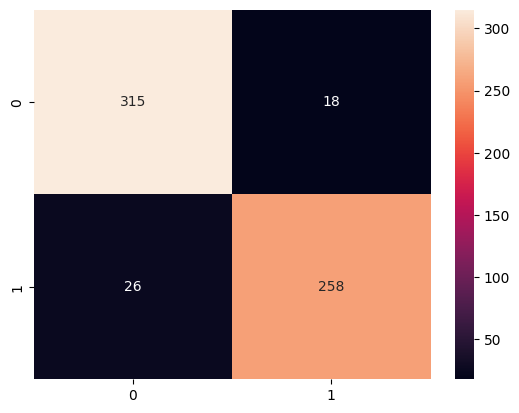

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

hfdMdd = featureDict["HFD"]["mdd"]
hfdControl = featureDict["HFD"]["control"]

X = np.concatenate((hfdMdd, hfdControl), axis=0)
y = np.concatenate((np.ones(len(hfdMdd)), np.zeros(len(hfdControl))), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print("accuracy_score: ", accuracy_score(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()